In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

In [16]:
class WeatherDataset(Dataset):
    def __init__(self, dataset_file, day_range, split_date, train_test="train"):

        # (Date, rainfall, maximum temp)
        df = pd.read_csv(dataset_file)
        # Turn date column into datetime type
        df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
        
        # Set the Date as the index
        df.set_index('Date', inplace=True)
        
        # Normalize the data
        mean = df.mean()
        std = df.std()
        df = (df - mean) / std

        # Calculate the mean and std dev
        self.mean = torch.tensor(mean.to_numpy()).reshape(1, -1)
        self.std = torch.tensor(std.to_numpy()).reshape(1, -1)

        # Get corresponding split
        if train_test == "train":
            self.dataset = df[df.index < split_date]
        elif train_test == "test":
            self.dataset = df[df.index >= split_date]
        else:
            ValueError("train_test should be train or test")

        # Get the day_range (# of days to take in as input)
        self.day_range = day_range
    
    def __getitem__(self, index):

        # Index a range of days
        end_index = index + self.day_range
        
        # One single item counts as 
        current_series = self.dataset.iloc[index:end_index]

        # Index the index column, and index into day, month
        # current_series.values returns the corresponding rainfall and maximum temperature
        day_tensor = torch.LongTensor(current_series.index.day.to_numpy())
        month_tensor = torch.LongTensor(current_series.index.month.to_numpy())
        data_values = torch.FloatTensor(current_series.values)

        return day_tensor, month_tensor, data_values

    def __len__(self):
        # __len__(,..,) is also used for determining when the end of a dataset is reached!
        # Exactly when len(self.dataset) - self.day_range == 0
        return len(self.dataset) - self.day_range


In [17]:
dataset_file = "weather.csv"

split_date = pd.to_datetime('2023-01-01')

day_range = 15

days_in = 14

assert day_range > days_in

learning_rate = 1e-4  
nepochs = 500  
batch_size = 32  

dataset_train = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="train")
dataset_test = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="test")

In [18]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of testing examples: {len(dataset_test)}')

Number of training examples: 3480
Number of testing examples: 412


In [19]:
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [31]:
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Define the layers for the residual block
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size // 2)
        
        self.norm2 = nn.LayerNorm(input_size // 2)
        self.fc2 = nn.Linear(input_size // 2, output_size)
        
        self.fc3 = nn.Linear(input_size, output_size)

        self.act = nn.ELU()

    def forward(self, x):
        # Forward pass of the residual block
        x = self.act(self.norm1(x))
        skip = self.fc3(x)
        
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        
        return x + skip


class LSTM(nn.Module):
    def __init__(self, seq_len, output_size, num_blocks=1):
        
        super(LSTM, self).__init__()
        
        seq_data_len = seq_len * 2

        self.input_mlp = nn.Sequential(nn.Linear(seq_data_len, 4 * seq_data_len), nn.ELU(), nn.Linear(4 * seq_data_len, 128))
        
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1)
        
        blocks = [ResBlockMLP(128, 128) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        
        self.fc_out = nn.Linear(128, output_size)
        self.act = nn.ELU()

    def forward(self, input_seq, hidden_in, mem_in):
        
        input_seq = input_seq.reshape(input_seq.shape[0], -1) # (bs, 28)
        
        input_vec = self.input_mlp(input_seq).unsqueeze(0) # (1, bs, 128)
        
        output, (hidden_out, mem_out) = self.lstm(input_vec, (hidden_in, mem_in))
        # output = (1, 32, 128)
        # hidden_out = (1, 32, 128)
        # mem = (1, 32, 128)

        x = self.act(self.res_blocks(output)).squeeze(0) # (32, 128)

        return self.fc_out(x), hidden_out, mem_out # (32, 2)

In [32]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

weather_lstm = LSTM(seq_len=days_in, output_size=2).to(device)

optimizer = optim.Adam(weather_lstm.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()

training_loss_logger = []

In [42]:
for epoch in range(nepochs):
    # Set the model to training mode
    weather_lstm.train()
    
    # Iterate over batches in the training data loader
    for day, month, data_seq in data_loader_train:
        # Extract input sequence block
        seq_block = data_seq[:, :days_in].to(device)
        
        # Initialize hidden state and memory tensors with zeros
        hidden = torch.zeros(1, data_seq.shape[0], 128, device=device)
        memory = torch.zeros(1, data_seq.shape[0], 128, device=device)

        # Initialize loss value
        loss = 0
        
        # Iterate over the sequence steps
        for i in range(day_range - days_in):
            # Extract target sequence block
            target_seq_block = data_seq[:, i + days_in].to(device)
            
            # Forward pass: predict using the input sequence block and update hidden states
            data_pred, hidden, memory = weather_lstm(seq_block, hidden, memory)
            
            # Accumulate the loss
            loss += loss_fn(data_pred, target_seq_block)

            # Update input sequence block by removing the oldest prediction and adding the new prediction
            seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1).detach()), 1)
        
        # Calculate the average loss
        loss /= i + 1
        
        # Backpropagation: compute gradients and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log the training loss
        training_loss_logger.append(loss.item())
    print(f"loss: {loss.item()}")

loss: 0.09314320236444473
loss: 0.06927869468927383
loss: 0.16623350977897644
loss: 0.09645873308181763
loss: 0.0657801404595375
loss: 0.09215278178453445
loss: 0.08162754774093628
loss: 0.12328390032052994
loss: 0.08460965007543564


KeyboardInterrupt: 

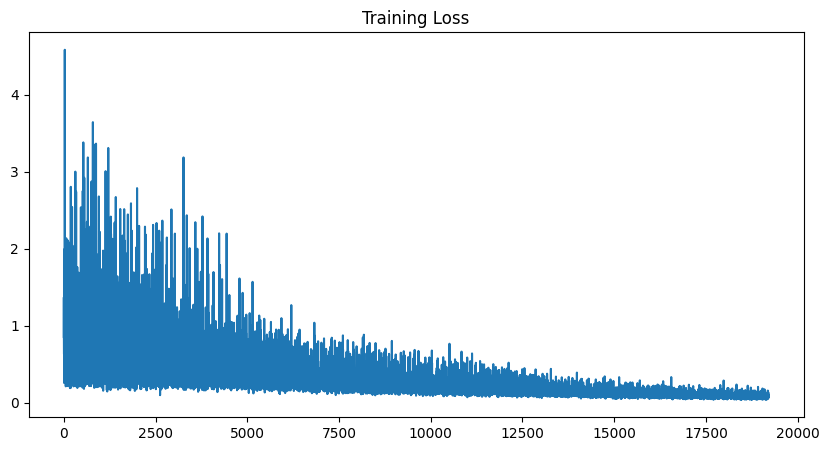

In [43]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

In [44]:
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

log_predictions = []
weather_lstm.eval() 

with torch.no_grad():
    seq_block = data_tensor[:days_in, :].unsqueeze(0).to(device)

    hidden = torch.zeros(1, seq_block.shape[0], 128, device=device)
    memory = torch.zeros(1, seq_block.shape[0], 128, device=device)
    
    # Iterate over the remaining days in the test dataset
    for i in range(data_tensor.shape[0] - days_in):
        
        # Predict the next day's weather using the LSTM model
        data_pred, hidden, memory = weather_lstm(seq_block, hidden, memory)
        
        # Update the input sequence block by removing the oldest prediction and adding the new prediction
        seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1)
        
        # Append the predicted weather values to the list
        log_predictions.append(data_pred.cpu())

predictions_cat = torch.cat(log_predictions)

un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean

un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean

un_norm_data = un_norm_data[days_in:]

In [45]:
test_mse = (un_norm_data - un_norm_predictions).pow(2).mean().item()
print("Test MSE value %.2f" % test_mse)

Test MSE value 59.83


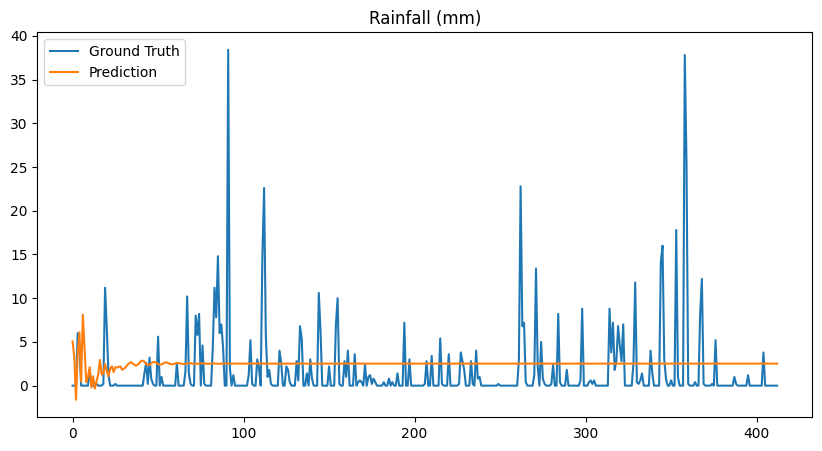

In [46]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 0])
_ = plt.plot(un_norm_predictions[:, 0])
_ = plt.title("Rainfall (mm)")

_ = plt.legend(["Ground Truth", "Prediction"])

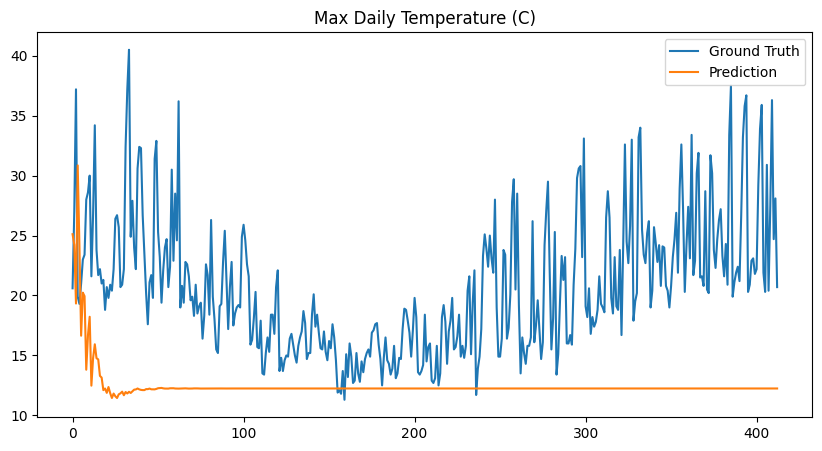

In [47]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 1])
_ = plt.plot(un_norm_predictions[:, 1])
_ = plt.title("Max Daily Temperature (C)")

_ = plt.legend(["Ground Truth", "Prediction"])